In [1]:
import sys
import numpy as np
import mxnet as mx
import time
import cPickle
# import custom_layers
import logging

/train/results/dev/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def ConvFactory(data, num_filter, kernel, stride=(1, 1), pad=(0, 0), act_type="relu", mirror_attr={}, with_act=True, namepre='', args=None):
  if args is None:
    weight = mx.sym.Variable(namepre+'_weight')
    bias = mx.sym.Variable(namepre+'_bias')
    gamma = mx.sym.Variable(namepre+'_gamma')
    beta = mx.sym.Variable(namepre+'_beta')
    args = {'weight':weight, 'bias':bias}
  else:
    weight = args['weight']
    bias = args['bias']
    gamma = args['gamma']
    beta = args['beta']
  
  conv = mx.symbol.Convolution(data=data, num_filter=num_filter, kernel=kernel, stride=stride, pad=pad, weight=weight, bias=bias, name=namepre+'_conv')
  bn = mx.symbol.BatchNorm(data=conv, gamma=gamma, beta=beta, name=namepre+'_bn')
  act = bn
  if with_act:
      act = mx.symbol.Activation(data=bn, act_type=act_type, attr=mirror_attr, name=namepre+'_act')
  return act, args


def stem(data, namepre='', args=None):
  if args is None:
    args = {'conv1a_3_3':None, 'conv2a_3_3':None, 'conv2b_3_3':None, 'conv3b_1_1':None, 'conv4a_3_3':None}
  conv1a_3_3, args['conv1a_3_3'] = ConvFactory(data=data, num_filter=32,
                           kernel=(3, 3), stride=(2, 2), namepre=namepre+'_conv1a_3_3', args=args['conv1a_3_3'])
  conv2a_3_3, args['conv2a_3_3'] = ConvFactory(conv1a_3_3, 32, (3, 3), namepre=namepre+'_conv2a_3_3', args=args['conv2a_3_3'])
  conv2b_3_3, args['conv2b_3_3'] = ConvFactory(conv2a_3_3, 64, (3, 3), pad=(1, 1), namepre=namepre+'_conv2b_3_3', args=args['conv2b_3_3'])
  maxpool3a_3_3 = mx.symbol.Pooling(
      data=conv2b_3_3, kernel=(3, 3), stride=(2, 2), pool_type='max', name=namepre+'_maxpool3a_3_3')
  conv3b_1_1, args['conv3b_1_1'] = ConvFactory(maxpool3a_3_3, 80, (1, 1), namepre=namepre+'_conv3b_1_1', args=args['conv3b_1_1'])
  conv4a_3_3, args['conv4a_3_3'] = ConvFactory(conv3b_1_1, 192, (3, 3), namepre=namepre+'_conv4a_3_3', args=args['conv4a_3_3'])

  return conv4a_3_3, args 


def reductionA(conv4a_3_3, namepre='', args=None):
  if args is None:
    args = {'tower_conv':None, 'tower_conv1_0':None, 'tower_conv1_1':None, 'tower_conv2_0':None, 'tower_conv2_1':None, 'tower_conv2_2':None, 'tower_conv3_1':None}
  maxpool5a_3_3 = mx.symbol.Pooling(
      data=conv4a_3_3, kernel=(3, 3), stride=(2, 2), pool_type='max', name=namepre+'_maxpool5a_3_3')

  tower_conv, args['tower_conv'] = ConvFactory(maxpool5a_3_3, 96, (1, 1), namepre=namepre+'_tower_conv', args=args['tower_conv'])
  tower_conv1_0, args['tower_conv1_0'] = ConvFactory(maxpool5a_3_3, 48, (1, 1), namepre=namepre+'_tower_conv1_0', args=args['tower_conv1_0'])
  tower_conv1_1, args['tower_conv1_1'] = ConvFactory(tower_conv1_0, 64, (5, 5), pad=(2, 2), namepre=namepre+'_tower_conv1_1', args=args['tower_conv1_1'])

  tower_conv2_0, args['tower_conv2_0'] = ConvFactory(maxpool5a_3_3, 64, (1, 1), namepre=namepre+'_tower_conv2_0', args=args['tower_conv2_0'])
  tower_conv2_1, args['tower_conv2_1'] = ConvFactory(tower_conv2_0, 96, (3, 3), pad=(1, 1), namepre=namepre+'_tower_conv2_1', args=args['tower_conv2_1'])
  tower_conv2_2, args['tower_conv2_2'] = ConvFactory(tower_conv2_1, 96, (3, 3), pad=(1, 1), namepre=namepre+'_tower_conv2_2', args=args['tower_conv2_2'])

  tower_pool3_0 = mx.symbol.Pooling(data=maxpool5a_3_3, kernel=(
      3, 3), stride=(1, 1), pad=(1, 1), pool_type='avg', name=namepre+'_tower_pool3_0')
  tower_conv3_1, args['tower_conv3_1'] = ConvFactory(tower_pool3_0, 64, (1, 1), namepre=namepre+'_tower_conv3_1', args=args['tower_conv3_1'])
  tower_5b_out = mx.symbol.Concat(
      *[tower_conv, tower_conv1_1, tower_conv2_2, tower_conv3_1])
  return tower_5b_out, args 


def reductionB(net, namepre='', args=None):
  if args is None:
    args = {'tower_conv':None, 'tower_conv1_0':None, 'tower_conv1_1':None, 'tower_conv1_2':None}
  tower_conv, args['tower_conv'] = ConvFactory(net, 384, (3, 3), stride=(2, 2), namepre=namepre+'_tower_conv', args=args['tower_conv'])
  tower_conv1_0, args['tower_conv1_0'] = ConvFactory(net, 256, (1, 1), namepre=namepre+'_tower_conv1_0', args=args['tower_conv1_0'])
  tower_conv1_1, args['tower_conv1_1'] = ConvFactory(tower_conv1_0, 256, (3, 3), pad=(1, 1), namepre=namepre+'_tower_conv1_1', args=args['tower_conv1_1'])
  tower_conv1_2, args['tower_conv1_2'] = ConvFactory(tower_conv1_1, 384, (3, 3), stride=(2, 2), namepre=namepre+'_tower_conv1_2', args=args['tower_conv1_2'])
  tower_pool = mx.symbol.Pooling(net, kernel=(
      3, 3), stride=(2, 2), pool_type='max', name=namepre+'_tower_pool')
  net = mx.symbol.Concat(*[tower_conv, tower_conv1_2, tower_pool])

  return net, args


def reductionC(net, namepre='', args=None):
  if args is None:
    args = {'tower_conv':None, 'tower_conv0_1':None, 'tower_conv1':None, 'tower_conv1_1':None, 'tower_conv2':None, 'tower_conv2_1':None, 'tower_conv2_2':None}
  tower_conv, args['tower_conv'] = ConvFactory(net, 256, (1, 1), namepre=namepre+'_tower_conv', args=args['tower_conv'])
  tower_conv0_1, args['tower_conv0_1'] = ConvFactory(tower_conv, 384, (3, 3), stride=(2, 2), namepre=namepre+'_tower_conv0_1', args=args['tower_conv0_1'])
  tower_conv1, args['tower_conv1'] = ConvFactory(net, 256, (1, 1), namepre=namepre+'_tower_conv1', args=args['tower_conv1'])
  tower_conv1_1, args['tower_conv1_1'] = ConvFactory(tower_conv1, 288, (3, 3), stride=(2, 2), namepre=namepre+'_tower_conv1_1', args=args['tower_conv1_1'])
  tower_conv2, args['tower_conv2'] = ConvFactory(net, 256, (1, 1), namepre=namepre+'_tower_conv2', args=args['tower_conv2'])
  tower_conv2_1, args['tower_conv2_1'] = ConvFactory(tower_conv2, 288, (3, 3), pad=(1, 1), namepre=namepre+'_tower_conv2_1', args=args['tower_conv2_1'])
  tower_conv2_2, args['tower_conv2_2'] = ConvFactory(tower_conv2_1, 320, (3, 3),  stride=(2, 2), namepre=namepre+'_tower_conv2_2', args=args['tower_conv2_2'])
  tower_pool = mx.symbol.Pooling(net, kernel=(3, 3), stride=(2, 2), pool_type='max', name=namepre+'_tower_pool')
  net = mx.symbol.Concat(*[tower_conv0_1, tower_conv1_1, tower_conv2_2, tower_pool])
  return net, args


def block35(net, input_num_channels, scale=1.0, with_act=True, act_type='relu', mirror_attr={}, namepre='', args=None):
  if args is None:
    args = {'tower_conv':None, 'tower_conv1_0':None, 'tower_conv1_1':None, 'tower_conv2_0':None, 'tower_conv2_1':None, 'tower_conv2_2':None, 'tower_out':None}
  tower_conv, args['tower_conv'] = ConvFactory(net, 32, (1, 1), namepre=namepre+'_tower_conv', args=args['tower_conv'])
  tower_conv1_0, args['tower_conv1_0'] = ConvFactory(net, 32, (1, 1), namepre=namepre+'_tower_conv1_0', args=args['tower_conv1_0'])
  tower_conv1_1, args['tower_conv1_1'] = ConvFactory(tower_conv1_0, 32, (3, 3), pad=(1, 1), namepre=namepre+'_tower_conv1_1', args=args['tower_conv1_1'])
  tower_conv2_0, args['tower_conv2_0'] = ConvFactory(net, 32, (1, 1), namepre=namepre+'_tower_conv2_0', args=args['tower_conv2_0'])
  tower_conv2_1, args['tower_conv2_1'] = ConvFactory(tower_conv2_0, 48, (3, 3), pad=(1, 1), namepre=namepre+'_tower_conv2_1', args=args['tower_conv2_1'])
  tower_conv2_2, args['tower_conv2_2'] = ConvFactory(tower_conv2_1, 64, (3, 3), pad=(1, 1), namepre=namepre+'_tower_conv2_2', args=args['tower_conv2_2'])
  tower_mixed = mx.symbol.Concat(*[tower_conv, tower_conv1_1, tower_conv2_2])
  tower_out, args['tower_out'] = ConvFactory(
      tower_mixed, input_num_channels, (1, 1), with_act=False, namepre=namepre+'_tower_out', args=args['tower_out'])

  net = net + scale * tower_out
  act = net
  if with_act:
      act = mx.symbol.Activation(
          data=net, act_type=act_type, attr=mirror_attr, name=namepre+'_act')
  return act, args


def block17(net, input_num_channels, scale=1.0, with_act=True, act_type='relu', mirror_attr={}, namepre='', args=None):
  if args is None:
    args = {'tower_conv':None, 'tower_conv1_0':None, 'tower_conv1_1':None, 'tower_conv1_2':None, 'tower_out':None}
  tower_conv, args['tower_conv'] = ConvFactory(net, 192, (1, 1), namepre=namepre+'_tower_conv', args=args['tower_conv'])
  tower_conv1_0, args['tower_conv1_0'] = ConvFactory(net, 129, (1, 1), namepre=namepre+'_tower_conv1_0', args=args['tower_conv1_0'])
  tower_conv1_1, args['tower_conv1_1'] = ConvFactory(tower_conv1_0, 160, (1, 7), pad=(1, 2), namepre=namepre+'_tower_conv1_1', args=args['tower_conv1_1'])
  tower_conv1_2, args['tower_conv1_2'] = ConvFactory(tower_conv1_1, 192, (7, 1), pad=(2, 1), namepre=namepre+'_tower_conv1_2', args=args['tower_conv1_2'])
  tower_mixed = mx.symbol.Concat(*[tower_conv, tower_conv1_2])
  tower_out, args['tower_out'] = ConvFactory(
      tower_mixed, input_num_channels, (1, 1), with_act=False, namepre=namepre+'_tower_out', args=args['tower_out'])
  net = net + scale * tower_out
  act = net
  if with_act:
      act = mx.symbol.Activation(
          data=net, act_type=act_type, attr=mirror_attr, name=namepre+'_act')
  return act, args


def block8(net, input_num_channels, scale=1.0, with_act=True, act_type='relu', mirror_attr={}, namepre='', args=None):
  if args is None:
    args = {'tower_conv':None, 'tower_conv1_0':None, 'tower_conv1_1':None, 'tower_conv1_2':None, 'tower_out':None}
  tower_conv, args['tower_conv'] = ConvFactory(net, 192, (1, 1), namepre=namepre+'_tower_conv', args=args['tower_conv'])
  tower_conv1_0, args['tower_conv1_0'] = ConvFactory(net, 192, (1, 1), namepre=namepre+'_tower_conv1_0', args=args['tower_conv1_0'])
  tower_conv1_1, args['tower_conv1_1'] = ConvFactory(tower_conv1_0, 224, (1, 3), pad=(0, 1), namepre=namepre+'_tower_conv1_1', args=args['tower_conv1_1'])
  tower_conv1_2, args['tower_conv1_2'] = ConvFactory(tower_conv1_1, 256, (3, 1), pad=(1, 0), namepre=namepre+'_tower_conv1_2', args=args['tower_conv1_2'])
  tower_mixed = mx.symbol.Concat(*[tower_conv, tower_conv1_2])
  tower_out, args['tower_out'] = ConvFactory(
      tower_mixed, input_num_channels, (1, 1), with_act=False, namepre=namepre+'_tower_out', args=args['tower_out'])
  net = net + scale * tower_out
  act = net
  if with_act:
      act = mx.symbol.Activation(
          data=net, act_type=act_type, attr=mirror_attr, name=namepre+'_act')
  return act, args


def repeat(inputs, repetitions, layer, *ltargs, **kwargs):
  outputs = inputs
  namepre = kwargs['namepre']
  args = kwargs['args']
  if args is None:
    args = {}
    for i in xrange(repetitions):
      argname='repeat_'+str(i)
      args[argname] = None
  for i in range(repetitions):
    kwargs['namepre'] = namepre+'_'+str(i)
    argname='repeat_'+str(i)
    kwargs['args'] = args[argname]
#    print ltargs
#    print kwargs
    outputs, args[argname] = layer(outputs, *ltargs, **kwargs)

  return outputs, args


def create_inception_resnet_v2(data, namepre='', args=None):
  if args is None:
    args = {'stem':None, 'reductionA':None, 'repeat_block35':None, 'reductionB':None, 
            'repeat_block17':None, 'reductionC':None, 'repeat_block8':None, 
            'final_block8':None, 'final_conv':None, 'finalfc':None}

  stem_net, args['stem']= stem(data, namepre=namepre+'_stem', args=args['stem'])

  reduceA, args['reductionA'] = reductionA(stem_net, namepre=namepre+'_reductionA', args=args['reductionA'])

  repeat_block35, args['repeat_block35'] = repeat(reduceA, 2, block35, scale=0.17, input_num_channels=320, namepre=namepre+'_repeat_block35', args=args['repeat_block35'])


  reduceB, args['reductionB'] = reductionB(repeat_block35, namepre=namepre+'_reductionB', args=args['reductionB'])

  repeat_block17, args['repeat_block17'] = repeat(reduceB, 4, block17, scale=0.1, input_num_channels=1088, namepre=namepre+'_repeat_block17', args=args['repeat_block17'])

  reduceC, args['reductionC'] = reductionC(repeat_block17, namepre=namepre+'_reductionC', args=args['reductionC'])

  repeat_block8, args['repeat_block8'] = repeat(reduceC, 2, block8, scale=0.2, input_num_channels=2080, namepre=namepre+'_repeat_block8', args=args['repeat_block8'])
  final_block8, args['final_block8'] = block8(repeat_block8, with_act=False, input_num_channels=2080, namepre=namepre+'_final_block8', args=args['final_block8'])

  final_conv, args['final_conv'] = ConvFactory(final_block8, 1536, (1, 1), namepre=namepre+'_final_conv', args=args['final_conv'])
  final_pool = mx.symbol.Pooling(final_conv, kernel=(8, 8), global_pool=True, pool_type='avg', name=namepre+'_final_pool')
#   final_pool = mx.symbol.Pooling(final_conv, kernel=(5, 5), stride=(1, 1), pool_type='avg', name=namepre+'_final_pool')
  final_flatten = mx.symbol.Flatten(final_pool, name=namepre+'_final_flatten')

  drop1 = mx.sym.Dropout(data=final_flatten, p=0.5, name=namepre+'_dropout1')

  if args['finalfc'] is None:
    args['finalfc'] = {}
    args['finalfc']['weight'] = mx.sym.Variable(namepre+'_fc1_weight')
    args['finalfc']['bias'] = mx.sym.Variable(namepre+'_fc1_bias')
    
  reid_fc1 = mx.sym.FullyConnected(data=drop1, num_hidden=512, name=namepre+"_fc1", 
                                   weight=args['finalfc']['weight'], bias=args['finalfc']['bias']) 
#  reid_act = mx.sym.Activation(data=reid_fc1, act_type='tanh', name=namepre+'_fc1_relu')

  net = reid_fc1
#  net = final_flatten

  return net, args

In [3]:
def create_net(data, hardratio, radius):
#     data = mx.sym.Variable('data')
    args_all = None
    feat_final, args_all = create_inception_resnet_v2(data, namepre='part1', args=args_all)
    feat_final = mx.sym.BatchNorm(data=feat_final, fix_gamma=False, name='feat_bn1')


    min_value =10**-36
    norm_value = radius
    #  norm_value = 24
    logging.info('norm_value:%f, min_value:%e, hardratio:%f', norm_value, min_value, hardratio)

    #norm
    znorm_loss = None
    if norm_value>0:
    #    proxy_Z = mx.sym.L2Normalization(proxy_Z) * norm_value
    #    feat_final = mx.sym.L2Normalization(feat_final) * norm_value
#         proxy_Znorm = mx.sym.sum_axis(proxy_Z**2, axis=1)
#         proxy_Znorm = mx.sym.sqrt(proxy_Znorm) + min_value

#     #    znorm_loss = mx.sym.abs(proxy_Znorm - 1.0)
#     #    znorm_loss = mx.sym.sum(znorm_loss)
#     #    znorm_loss = mx.sym.MakeLoss(znorm_loss)

#         proxy_Znorm = mx.sym.Reshape(proxy_Znorm, shape=(-2, 1))
#         proxy_Z = mx.sym.broadcast_div(proxy_Z, proxy_Znorm)# * norm_value

        feat_finalnorm = mx.sym.sum_axis(feat_final**2, axis=1)
        feat_finalnorm = mx.sym.sqrt(feat_finalnorm) + min_value
        feat_finalnorm = mx.sym.Reshape(feat_finalnorm, shape=(-2, 1))
        feat_final = mx.sym.broadcast_div(feat_final, feat_finalnorm) * norm_value
#     X = mx.nd.empty(shape=(64, 10000000), ctx=mx.cpu(0))
    return feat_final



In [48]:
del mod

In [49]:
data = mx.sym.Variable('data')
batchsize = 64
data_shape = (batchsize, 3, 240, 120)
hardratio = 0.0001
radius = 0
lr = 0.01
beta1 = 0.9
ctx = mx.gpu(0)
part_net = create_net(data, hardratio, radius)
mod = mx.mod.Module(symbol=part_net, data_names=("data",), context=ctx)
mod.bind(data_shapes=[('data', data_shape)], inputs_need_grad=True)

In [50]:

data_batch = mx.random.normal(0, 1.0, shape=data_shape)
print data_batch.shape

(64L, 3L, 240L, 120L)


In [51]:
lr_start = 1 #0.2 #0.1 #0.02 #0.05 #0.57 
#lr_min = 10**-5
lr_min = 10**-5
lr_reduce = 0.4 #0.99
lr_stepnum = np.log(lr_min/lr_start)/np.log(lr_reduce)
lr_stepnum = np.int(np.ceil(lr_stepnum))
dlr = 1050/batchsize
dlr_steps = [dlr*i for i in xrange(1, lr_stepnum+1)]
print dlr_steps
print 'lr_start:%.1e, lr_min:%.1e, lr_reduce:%.2f, lr_stepsnum:%d'%(lr_start, lr_min, lr_reduce, lr_stepnum)
lr_scheduler = mx.lr_scheduler.MultiFactorScheduler(dlr_steps, lr_reduce)



[16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208]
lr_start:1.0e+00, lr_min:1.0e-05, lr_reduce:0.40, lr_stepsnum:13


In [17]:
dir(lr_scheduler)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'base_lr',
 'count',
 'cur_step_ind',
 'factor',
 'step']

In [16]:
lr_scheduler.base_lr

0.01

In [8]:
import matplotlib.pyplot as plt
def plot_schedule(schedule_fn, iterations=1500):
    # Iteration count starting at 1
    iterations = [i+1 for i in range(iterations)]
    lrs = [schedule_fn(i) for i in iterations]
    plt.scatter(iterations, lrs)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.show()

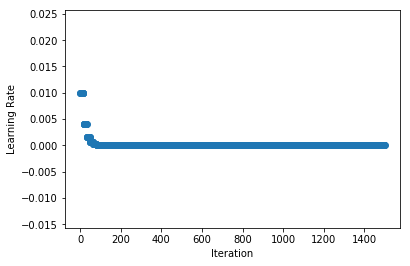

In [9]:
# lr_scheduler.base_lr = 1
plot_schedule(lr_scheduler)

In [52]:
mod.init_params(mx.init.Xavier(factor_type="in", magnitude=2.34))
mod.init_optimizer(optimizer="adam", 
                   optimizer_params={
                       "learning_rate": lr_start,
                       'lr_scheduler':lr_scheduler,
                       'clip_gradient':None,
                       "wd": 0.0005,
                       "beta1": beta1,
                   })

# mod._optimizer.lr_mult = [0.99]

In [33]:
mod.forward(mx.io.DataBatch([data_batch,]), is_train=True)

In [34]:
diff = mx.random.normal(0, 1.0, shape=(64, 512))
mod.backward([diff])

In [35]:
mod.update()

In [21]:
mod._optimizer.num_update = 0

In [53]:
for i in range(200):
    mod.forward(mx.io.DataBatch([data_batch,]), is_train=True)
    diff = mx.random.normal(0, 1.0, shape=(64, 512))
    mod.backward([diff])
    
    print mod._optimizer.num_update, mod._optimizer._get_lr(mod._optimizer.num_update)
#     print mod._optimizer.num_update, mod._optimizer.lr
    
    mod.update()
    

0 1.0
1 1.0
2 1.0
3 1.0
4 1.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0
10 1.0
11 1.0
12 1.0
13 1.0
14 1.0
15 1.0
16 1.0
17 0.4
18 0.4
19 0.4
20 0.4
21 0.4
22 0.4
23 0.4
24 0.4
25 0.4
26 0.4
27 0.4
28 0.4
29 0.4
30 0.4
31 0.4
32 0.4
33 0.16
34 0.16
35 0.16
36 0.16
37 0.16
38 0.16
39 0.16
40 0.16
41 0.16
42 0.16
43 0.16
44 0.16
45 0.16
46 0.16
47 0.16
48 0.16
49 0.064
50 0.064
51 0.064
52 0.064
53 0.064
54 0.064
55 0.064
56 0.064
57 0.064
58 0.064
59 0.064
60 0.064
61 0.064
62 0.064
63 0.064
64 0.064
65 0.0256
66 0.0256
67 0.0256
68 0.0256
69 0.0256
70 0.0256
71 0.0256
72 0.0256
73 0.0256
74 0.0256
75 0.0256
76 0.0256
77 0.0256
78 0.0256
79 0.0256
80 0.0256
81 0.01024
82 0.01024
83 0.01024
84 0.01024
85 0.01024
86 0.01024
87 0.01024
88 0.01024
89 0.01024
90 0.01024
91 0.01024
92 0.01024
93 0.01024
94 0.01024
95 0.01024
96 0.01024
97 0.004096
98 0.004096
99 0.004096
100 0.004096
101 0.004096
102 0.004096
103 0.004096
104 0.004096
105 0.004096
106 0.004096
107 0.004096
108 0.004096
109 0.004096
110 0

In [66]:
out = mod.get_outputs()

In [70]:
dir(mod._optimizer)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_lr',
 '_get_wd',
 '_index_update_count',
 '_update_count',
 'begin_num_update',
 'beta1',
 'beta2',
 'clip_gradient',
 'create_optimizer',
 'create_state',
 'create_state_multi_precision',
 'epsilon',
 'idx2name',
 'lazy_update',
 'learning_rate',
 'lr',
 'lr_mult',
 'lr_scheduler',
 'multi_precision',
 'num_update',
 'opt_registry',
 'param_dict',
 'register',
 'rescale_grad',
 'set_learning_rate',
 'set_lr_mult',
 'set_lr_scale',
 'set_wd_mult',
 'sym_info',
 'update',
 'update_multi_precision',
 'wd',
 'wd_mult']

In [13]:
print mod._optimizer.lr
print mod._optimizer.lr_mult
print mod._optimizer._get_lr(100)
print mod._optimizer.wd
print mod._optimizer.epsilon
print mod._optimizer.num_update
print mod._optimizer.beta1
print mod._optimizer.lr_scheduler
print mod._optimizer._update_count(mod._optimizer.num_update)
# print mod._optimizer.create_state(2, diff)

1
{}
1.0
0.0005
1e-08
201
0.9
None


In [28]:
dir(mx.optimizer.Adam)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_lr',
 '_get_wd',
 '_update_count',
 'create_optimizer',
 'create_state',
 'create_state_multi_precision',
 'learning_rate',
 'opt_registry',
 'register',
 'set_learning_rate',
 'set_lr_mult',
 'set_lr_scale',
 'set_wd_mult',
 'update',
 'update_multi_precision']

In [67]:
print out[0].asnumpy()

[[ 0.59400594 -0.18787093 -1.1587477  ... -0.3922908  -0.32442293
   0.40793994]
 [-0.8142539  -0.04978066  0.24333796 ... -0.02871937  0.32941356
  -0.76062626]
 [ 0.35996005 -0.80182177 -0.32823408 ... -0.8045763   0.09924796
   0.2688434 ]
 ...
 [ 0.81386065  0.95175695 -1.1954898  ...  0.45502654 -0.48312974
   0.7815472 ]
 [ 0.05001164 -1.193234    0.7274514  ...  0.5062809  -1.1382914
  -1.5131106 ]
 [-0.04340986  1.8692598   0.6630346  ...  0.7136798  -0.01621716
  -1.2960556 ]]


In [ ]:
#         proxy_Znorm = mx.sym.sum_axis(proxy_Z**2, axis=1)
#         proxy_Znorm = mx.sym.sqrt(proxy_Znorm) + min_value

#     #    znorm_loss = mx.sym.abs(proxy_Znorm - 1.0)
#     #    znorm_loss = mx.sym.sum(znorm_loss)
#     #    znorm_loss = mx.sym.MakeLoss(znorm_loss)

#         proxy_Znorm = mx.sym.Reshape(proxy_Znorm, shape=(-2, 1))
#         proxy_Z = mx.sym.broadcast_div(proxy_Z, proxy_Znorm)# * norm_value

['__add__',
 '__array_priority__',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__del__',
 '__delattr__',
 '__div__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__idiv__',
 '__imul__',
 '__init__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '_compose',
 '_get_ndarray_inputs',
 '_infer_shape_impl',
 '_set_attr',
 '_set_handle',
 'abs',
 'arccos',
 'arccosh',
 'arcsin',
 'arcsinh',
 'arctan',
 'arctanh',
 'argmax',
 'argmax_channel',
 'argmin',
 'argsort',
 'as_in_context',
 'asnumpy',
 'asscalar',


In [ ]:
class fc_forward(operator.CustomOp):
    def __init__(self, hardratio, handle):
        self.hardratio = float(hardratio)
        self.handle = handle
    def forward(self, is_train, req, in_data, out_data, aux):
        '''
            in_data: [feat_final, label, proxy_Z]
            
        '''
        X = in_data[0].asnumpy()
        y_true = in_data[1].asnumpy().reshape(-1,1).astype(np.int32)
        W = in_data[2]
        
        N = X.shape[0]
        M, C = W.shape
        
        self.score = np.empty((N, M), np.float32)
        def stream_cal_in_GPU()        
            cublasxt.cublasXtSgemm(self.handle,
                                   'N', 'N', 
                                   N, M, C, np.float32(1.0),
                                   X.ctypes.data, N, W.ctypes.data, C, np.float32(0.0),
                                   self.score.ctypes.data, N)
        cublasxt.cublasXtSetCpuRoutine(handle, 0, 0, stream_cal_in_GPU())
        # add hardratio
        self.score[range(N), y_true.reshape(-1)] += self.hardratio
        self.score = self.score - np.max(self.score, axis=1, keepdims=True)
        # exp_score = score
        self.score = np.exp(self.score)
        # probs = score
        self.score = self.score / np.sum(self.score, axis=1, keepdims=True)
        
        K = 999
        y_true_score = self.score[range(N), y_true.reshape(-1)]
        self.score[range(N), y_true.reshape(-1)] = self.score.min(axis = 1)
        TopK_idx = np.argpartition(self.score, -K, axis=1)[:, -K:]
        self.score[range(N), y_true.reshape(-1)] = y_true_score
        self.TopK_idx = np.hstack((TopK_idx, y_true))
        
        TopK_score = self.score[np.array(range(N)).reshape(-1,1), self.TopK_idx]
#         y_true_reform = np.array([K]*N).reshape(-1,1)
        
        self.assign(out_data[0], req[0], mx.nd.array(TopK_score))

    def backward(self, req, out_grad, in_data, out_data, in_grad, aux):
        d_TopK_score = out_grad[0].asnumpy()
        self.score[...] = 0
        N, M = self.score.shape
        self.score[np.array(range(N)).reshape(-1,1), self.TopK_idx] = d_TopK_score
        d_score = mx.nd.array(self.score, dtype='float32')
        csr_d_score = d_score.tostype('csr')
        
        feat_final = in_data[0]
        proxy_Z = mx.nd.array(in_data[2], dtype='float32')
        self.assign(in_grad[0], req[0], out_grad[0])

@operator.register("Matrix2DPlusCol")
class Matrix2DPlusCol_Prop(operator.CustomOpProp):
    def __init__(self, hardratio=0.0):
        super(Matrix2DPlusCol_Prop, self).__init__(need_top_grad=True)
        self.hardratio = hardratio
    
    def list_arguments(self):
        return ['data', 'label']

    def list_outputs(self):
        return ['output']

    def infer_shape(self, inshape):
        assert len(inshape[0])==2, 'only support 2D matrix...'
        data_shape = inshape[0]
        label_shape = inshape[1]
        return [data_shape, label_shape], [data_shape], []

    def create_operator(self, ctx, shapes, dtypes):
        return Matrix2DPlusCol(self.hardratio)

In [34]:
class fc():
    def __init__(self, a=1):
        self.b = 2
        
    def nc(self):
        self.c = 1
        return self.c
    def nb(self):
        self.b = 2
        self.c = 2
        return self.b, self.c
    def nbc(self):
        return self.b+self.c

In [35]:
a = fc()

In [36]:
print a.nc()

1


In [37]:
print a.nb()

(2, 2)


In [38]:
print a.nbc()

4


# Begin

In [1]:
import sys
import numpy as np
import mxnet as mx
import time
import cPickle
# import custom_layers
import logging

import skcuda.cublasxt as cublasxt
import math
import os

/train/results/dev/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# DataIter

In [4]:
batchsize = 64
data_shape = (batchsize, 3, 240, 120)
data_batch = mx.random.normal(0, 1.0, shape=data_shape)
data_label = mx.nd.array(range(64), dtype='int32')
DataIter = mx.io.DataBatch(data=[data_batch], label=[data_label])

(64L, 3L, 240L, 120L)


# Backbone

In [2]:
def ConvFactory(data, num_filter, kernel, stride=(1, 1), pad=(0, 0), act_type="relu", mirror_attr={}, with_act=True, namepre='', args=None):
  if args is None:
    weight = mx.sym.Variable(namepre+'_weight')
    bias = mx.sym.Variable(namepre+'_bias')
    gamma = mx.sym.Variable(namepre+'_gamma')
    beta = mx.sym.Variable(namepre+'_beta')
    args = {'weight':weight, 'bias':bias}
  else:
    weight = args['weight']
    bias = args['bias']
    gamma = args['gamma']
    beta = args['beta']
  
  conv = mx.symbol.Convolution(data=data, num_filter=num_filter, kernel=kernel, stride=stride, pad=pad, weight=weight, bias=bias, name=namepre+'_conv')
  bn = mx.symbol.BatchNorm(data=conv, gamma=gamma, beta=beta, name=namepre+'_bn')
  act = bn
  if with_act:
      act = mx.symbol.Activation(data=bn, act_type=act_type, attr=mirror_attr, name=namepre+'_act')
  return act, args


def stem(data, namepre='', args=None):
  if args is None:
    args = {'conv1a_3_3':None, 'conv2a_3_3':None, 'conv2b_3_3':None, 'conv3b_1_1':None, 'conv4a_3_3':None}
  conv1a_3_3, args['conv1a_3_3'] = ConvFactory(data=data, num_filter=32,
                           kernel=(3, 3), stride=(2, 2), namepre=namepre+'_conv1a_3_3', args=args['conv1a_3_3'])
  conv2a_3_3, args['conv2a_3_3'] = ConvFactory(conv1a_3_3, 32, (3, 3), namepre=namepre+'_conv2a_3_3', args=args['conv2a_3_3'])
  conv2b_3_3, args['conv2b_3_3'] = ConvFactory(conv2a_3_3, 64, (3, 3), pad=(1, 1), namepre=namepre+'_conv2b_3_3', args=args['conv2b_3_3'])
  maxpool3a_3_3 = mx.symbol.Pooling(
      data=conv2b_3_3, kernel=(3, 3), stride=(2, 2), pool_type='max', name=namepre+'_maxpool3a_3_3')
  conv3b_1_1, args['conv3b_1_1'] = ConvFactory(maxpool3a_3_3, 80, (1, 1), namepre=namepre+'_conv3b_1_1', args=args['conv3b_1_1'])
  conv4a_3_3, args['conv4a_3_3'] = ConvFactory(conv3b_1_1, 192, (3, 3), namepre=namepre+'_conv4a_3_3', args=args['conv4a_3_3'])

  return conv4a_3_3, args 


def reductionA(conv4a_3_3, namepre='', args=None):
  if args is None:
    args = {'tower_conv':None, 'tower_conv1_0':None, 'tower_conv1_1':None, 'tower_conv2_0':None, 'tower_conv2_1':None, 'tower_conv2_2':None, 'tower_conv3_1':None}
  maxpool5a_3_3 = mx.symbol.Pooling(
      data=conv4a_3_3, kernel=(3, 3), stride=(2, 2), pool_type='max', name=namepre+'_maxpool5a_3_3')

  tower_conv, args['tower_conv'] = ConvFactory(maxpool5a_3_3, 96, (1, 1), namepre=namepre+'_tower_conv', args=args['tower_conv'])
  tower_conv1_0, args['tower_conv1_0'] = ConvFactory(maxpool5a_3_3, 48, (1, 1), namepre=namepre+'_tower_conv1_0', args=args['tower_conv1_0'])
  tower_conv1_1, args['tower_conv1_1'] = ConvFactory(tower_conv1_0, 64, (5, 5), pad=(2, 2), namepre=namepre+'_tower_conv1_1', args=args['tower_conv1_1'])

  tower_conv2_0, args['tower_conv2_0'] = ConvFactory(maxpool5a_3_3, 64, (1, 1), namepre=namepre+'_tower_conv2_0', args=args['tower_conv2_0'])
  tower_conv2_1, args['tower_conv2_1'] = ConvFactory(tower_conv2_0, 96, (3, 3), pad=(1, 1), namepre=namepre+'_tower_conv2_1', args=args['tower_conv2_1'])
  tower_conv2_2, args['tower_conv2_2'] = ConvFactory(tower_conv2_1, 96, (3, 3), pad=(1, 1), namepre=namepre+'_tower_conv2_2', args=args['tower_conv2_2'])

  tower_pool3_0 = mx.symbol.Pooling(data=maxpool5a_3_3, kernel=(
      3, 3), stride=(1, 1), pad=(1, 1), pool_type='avg', name=namepre+'_tower_pool3_0')
  tower_conv3_1, args['tower_conv3_1'] = ConvFactory(tower_pool3_0, 64, (1, 1), namepre=namepre+'_tower_conv3_1', args=args['tower_conv3_1'])
  tower_5b_out = mx.symbol.Concat(
      *[tower_conv, tower_conv1_1, tower_conv2_2, tower_conv3_1])
  return tower_5b_out, args 


def reductionB(net, namepre='', args=None):
  if args is None:
    args = {'tower_conv':None, 'tower_conv1_0':None, 'tower_conv1_1':None, 'tower_conv1_2':None}
  tower_conv, args['tower_conv'] = ConvFactory(net, 384, (3, 3), stride=(2, 2), namepre=namepre+'_tower_conv', args=args['tower_conv'])
  tower_conv1_0, args['tower_conv1_0'] = ConvFactory(net, 256, (1, 1), namepre=namepre+'_tower_conv1_0', args=args['tower_conv1_0'])
  tower_conv1_1, args['tower_conv1_1'] = ConvFactory(tower_conv1_0, 256, (3, 3), pad=(1, 1), namepre=namepre+'_tower_conv1_1', args=args['tower_conv1_1'])
  tower_conv1_2, args['tower_conv1_2'] = ConvFactory(tower_conv1_1, 384, (3, 3), stride=(2, 2), namepre=namepre+'_tower_conv1_2', args=args['tower_conv1_2'])
  tower_pool = mx.symbol.Pooling(net, kernel=(
      3, 3), stride=(2, 2), pool_type='max', name=namepre+'_tower_pool')
  net = mx.symbol.Concat(*[tower_conv, tower_conv1_2, tower_pool])

  return net, args


def reductionC(net, namepre='', args=None):
  if args is None:
    args = {'tower_conv':None, 'tower_conv0_1':None, 'tower_conv1':None, 'tower_conv1_1':None, 'tower_conv2':None, 'tower_conv2_1':None, 'tower_conv2_2':None}
  tower_conv, args['tower_conv'] = ConvFactory(net, 256, (1, 1), namepre=namepre+'_tower_conv', args=args['tower_conv'])
  tower_conv0_1, args['tower_conv0_1'] = ConvFactory(tower_conv, 384, (3, 3), stride=(2, 2), namepre=namepre+'_tower_conv0_1', args=args['tower_conv0_1'])
  tower_conv1, args['tower_conv1'] = ConvFactory(net, 256, (1, 1), namepre=namepre+'_tower_conv1', args=args['tower_conv1'])
  tower_conv1_1, args['tower_conv1_1'] = ConvFactory(tower_conv1, 288, (3, 3), stride=(2, 2), namepre=namepre+'_tower_conv1_1', args=args['tower_conv1_1'])
  tower_conv2, args['tower_conv2'] = ConvFactory(net, 256, (1, 1), namepre=namepre+'_tower_conv2', args=args['tower_conv2'])
  tower_conv2_1, args['tower_conv2_1'] = ConvFactory(tower_conv2, 288, (3, 3), pad=(1, 1), namepre=namepre+'_tower_conv2_1', args=args['tower_conv2_1'])
  tower_conv2_2, args['tower_conv2_2'] = ConvFactory(tower_conv2_1, 320, (3, 3),  stride=(2, 2), namepre=namepre+'_tower_conv2_2', args=args['tower_conv2_2'])
  tower_pool = mx.symbol.Pooling(net, kernel=(3, 3), stride=(2, 2), pool_type='max', name=namepre+'_tower_pool')
  net = mx.symbol.Concat(*[tower_conv0_1, tower_conv1_1, tower_conv2_2, tower_pool])
  return net, args


def block35(net, input_num_channels, scale=1.0, with_act=True, act_type='relu', mirror_attr={}, namepre='', args=None):
  if args is None:
    args = {'tower_conv':None, 'tower_conv1_0':None, 'tower_conv1_1':None, 'tower_conv2_0':None, 'tower_conv2_1':None, 'tower_conv2_2':None, 'tower_out':None}
  tower_conv, args['tower_conv'] = ConvFactory(net, 32, (1, 1), namepre=namepre+'_tower_conv', args=args['tower_conv'])
  tower_conv1_0, args['tower_conv1_0'] = ConvFactory(net, 32, (1, 1), namepre=namepre+'_tower_conv1_0', args=args['tower_conv1_0'])
  tower_conv1_1, args['tower_conv1_1'] = ConvFactory(tower_conv1_0, 32, (3, 3), pad=(1, 1), namepre=namepre+'_tower_conv1_1', args=args['tower_conv1_1'])
  tower_conv2_0, args['tower_conv2_0'] = ConvFactory(net, 32, (1, 1), namepre=namepre+'_tower_conv2_0', args=args['tower_conv2_0'])
  tower_conv2_1, args['tower_conv2_1'] = ConvFactory(tower_conv2_0, 48, (3, 3), pad=(1, 1), namepre=namepre+'_tower_conv2_1', args=args['tower_conv2_1'])
  tower_conv2_2, args['tower_conv2_2'] = ConvFactory(tower_conv2_1, 64, (3, 3), pad=(1, 1), namepre=namepre+'_tower_conv2_2', args=args['tower_conv2_2'])
  tower_mixed = mx.symbol.Concat(*[tower_conv, tower_conv1_1, tower_conv2_2])
  tower_out, args['tower_out'] = ConvFactory(
      tower_mixed, input_num_channels, (1, 1), with_act=False, namepre=namepre+'_tower_out', args=args['tower_out'])

  net = net + scale * tower_out
  act = net
  if with_act:
      act = mx.symbol.Activation(
          data=net, act_type=act_type, attr=mirror_attr, name=namepre+'_act')
  return act, args


def block17(net, input_num_channels, scale=1.0, with_act=True, act_type='relu', mirror_attr={}, namepre='', args=None):
  if args is None:
    args = {'tower_conv':None, 'tower_conv1_0':None, 'tower_conv1_1':None, 'tower_conv1_2':None, 'tower_out':None}
  tower_conv, args['tower_conv'] = ConvFactory(net, 192, (1, 1), namepre=namepre+'_tower_conv', args=args['tower_conv'])
  tower_conv1_0, args['tower_conv1_0'] = ConvFactory(net, 129, (1, 1), namepre=namepre+'_tower_conv1_0', args=args['tower_conv1_0'])
  tower_conv1_1, args['tower_conv1_1'] = ConvFactory(tower_conv1_0, 160, (1, 7), pad=(1, 2), namepre=namepre+'_tower_conv1_1', args=args['tower_conv1_1'])
  tower_conv1_2, args['tower_conv1_2'] = ConvFactory(tower_conv1_1, 192, (7, 1), pad=(2, 1), namepre=namepre+'_tower_conv1_2', args=args['tower_conv1_2'])
  tower_mixed = mx.symbol.Concat(*[tower_conv, tower_conv1_2])
  tower_out, args['tower_out'] = ConvFactory(
      tower_mixed, input_num_channels, (1, 1), with_act=False, namepre=namepre+'_tower_out', args=args['tower_out'])
  net = net + scale * tower_out
  act = net
  if with_act:
      act = mx.symbol.Activation(
          data=net, act_type=act_type, attr=mirror_attr, name=namepre+'_act')
  return act, args


def block8(net, input_num_channels, scale=1.0, with_act=True, act_type='relu', mirror_attr={}, namepre='', args=None):
  if args is None:
    args = {'tower_conv':None, 'tower_conv1_0':None, 'tower_conv1_1':None, 'tower_conv1_2':None, 'tower_out':None}
  tower_conv, args['tower_conv'] = ConvFactory(net, 192, (1, 1), namepre=namepre+'_tower_conv', args=args['tower_conv'])
  tower_conv1_0, args['tower_conv1_0'] = ConvFactory(net, 192, (1, 1), namepre=namepre+'_tower_conv1_0', args=args['tower_conv1_0'])
  tower_conv1_1, args['tower_conv1_1'] = ConvFactory(tower_conv1_0, 224, (1, 3), pad=(0, 1), namepre=namepre+'_tower_conv1_1', args=args['tower_conv1_1'])
  tower_conv1_2, args['tower_conv1_2'] = ConvFactory(tower_conv1_1, 256, (3, 1), pad=(1, 0), namepre=namepre+'_tower_conv1_2', args=args['tower_conv1_2'])
  tower_mixed = mx.symbol.Concat(*[tower_conv, tower_conv1_2])
  tower_out, args['tower_out'] = ConvFactory(
      tower_mixed, input_num_channels, (1, 1), with_act=False, namepre=namepre+'_tower_out', args=args['tower_out'])
  net = net + scale * tower_out
  act = net
  if with_act:
      act = mx.symbol.Activation(
          data=net, act_type=act_type, attr=mirror_attr, name=namepre+'_act')
  return act, args


def repeat(inputs, repetitions, layer, *ltargs, **kwargs):
  outputs = inputs
  namepre = kwargs['namepre']
  args = kwargs['args']
  if args is None:
    args = {}
    for i in xrange(repetitions):
      argname='repeat_'+str(i)
      args[argname] = None
  for i in range(repetitions):
    kwargs['namepre'] = namepre+'_'+str(i)
    argname='repeat_'+str(i)
    kwargs['args'] = args[argname]
#    print ltargs
#    print kwargs
    outputs, args[argname] = layer(outputs, *ltargs, **kwargs)

  return outputs, args


def create_inception_resnet_v2(data, namepre='', args=None):
  if args is None:
    args = {'stem':None, 'reductionA':None, 'repeat_block35':None, 'reductionB':None, 
            'repeat_block17':None, 'reductionC':None, 'repeat_block8':None, 
            'final_block8':None, 'final_conv':None, 'finalfc':None}

  stem_net, args['stem']= stem(data, namepre=namepre+'_stem', args=args['stem'])

  reduceA, args['reductionA'] = reductionA(stem_net, namepre=namepre+'_reductionA', args=args['reductionA'])

  repeat_block35, args['repeat_block35'] = repeat(reduceA, 2, block35, scale=0.17, input_num_channels=320, namepre=namepre+'_repeat_block35', args=args['repeat_block35'])


  reduceB, args['reductionB'] = reductionB(repeat_block35, namepre=namepre+'_reductionB', args=args['reductionB'])

  repeat_block17, args['repeat_block17'] = repeat(reduceB, 4, block17, scale=0.1, input_num_channels=1088, namepre=namepre+'_repeat_block17', args=args['repeat_block17'])

  reduceC, args['reductionC'] = reductionC(repeat_block17, namepre=namepre+'_reductionC', args=args['reductionC'])

  repeat_block8, args['repeat_block8'] = repeat(reduceC, 2, block8, scale=0.2, input_num_channels=2080, namepre=namepre+'_repeat_block8', args=args['repeat_block8'])
  final_block8, args['final_block8'] = block8(repeat_block8, with_act=False, input_num_channels=2080, namepre=namepre+'_final_block8', args=args['final_block8'])

  final_conv, args['final_conv'] = ConvFactory(final_block8, 1536, (1, 1), namepre=namepre+'_final_conv', args=args['final_conv'])
  final_pool = mx.symbol.Pooling(final_conv, kernel=(8, 8), global_pool=True, pool_type='avg', name=namepre+'_final_pool')
#   final_pool = mx.symbol.Pooling(final_conv, kernel=(5, 5), stride=(1, 1), pool_type='avg', name=namepre+'_final_pool')
  final_flatten = mx.symbol.Flatten(final_pool, name=namepre+'_final_flatten')

  drop1 = mx.sym.Dropout(data=final_flatten, p=0.5, name=namepre+'_dropout1')

  if args['finalfc'] is None:
    args['finalfc'] = {}
    args['finalfc']['weight'] = mx.sym.Variable(namepre+'_fc1_weight')
    args['finalfc']['bias'] = mx.sym.Variable(namepre+'_fc1_bias')
    
  reid_fc1 = mx.sym.FullyConnected(data=drop1, num_hidden=128, name=namepre+"_fc1", 
                                   weight=args['finalfc']['weight'], bias=args['finalfc']['bias']) 
#  reid_act = mx.sym.Activation(data=reid_fc1, act_type='tanh', name=namepre+'_fc1_relu')

  net = reid_fc1
#  net = final_flatten

  return net, args

In [3]:
def create_net(data, radius):
#     data = mx.sym.Variable('data')
    args_all = None
    feat_final, args_all = create_inception_resnet_v2(data, namepre='part1', args=args_all)
    feat_final = mx.sym.BatchNorm(data=feat_final, fix_gamma=False, name='feat_bn1')


    min_value =10**-36
    norm_value = radius
    #  norm_value = 24
    logging.info('norm_value:%f, min_value:%e, hardratio:%f', norm_value, min_value, hardratio)

    #norm
    znorm_loss = None
    if norm_value>0:
    #    proxy_Z = mx.sym.L2Normalization(proxy_Z) * norm_value
    #    feat_final = mx.sym.L2Normalization(feat_final) * norm_value
#         proxy_Znorm = mx.sym.sum_axis(proxy_Z**2, axis=1)
#         proxy_Znorm = mx.sym.sqrt(proxy_Znorm) + min_value

#     #    znorm_loss = mx.sym.abs(proxy_Znorm - 1.0)
#     #    znorm_loss = mx.sym.sum(znorm_loss)
#     #    znorm_loss = mx.sym.MakeLoss(znorm_loss)

#         proxy_Znorm = mx.sym.Reshape(proxy_Znorm, shape=(-2, 1))
#         proxy_Z = mx.sym.broadcast_div(proxy_Z, proxy_Znorm)# * norm_value

        feat_finalnorm = mx.sym.sum_axis(feat_final**2, axis=1)
        feat_finalnorm = mx.sym.sqrt(feat_finalnorm) + min_value
        feat_finalnorm = mx.sym.Reshape(feat_finalnorm, shape=(-2, 1))
        feat_final = mx.sym.broadcast_div(feat_final, feat_finalnorm) * norm_value
#     X = mx.nd.empty(shape=(64, 10000000), ctx=mx.cpu(0))
    return feat_final

# Define module and update

In [4]:
class mixModule(object):
    def __init__(self, symbol, context, handle, data_shape, proxy_Z, K):
        self.mod = mx.mod.Module(symbol=symbol, 
                                 data_names=("data",), 
                                 label_names=None, 
                                 context=context)
        self.mod.bind(data_shapes=[("data", data_shape)])
        self.context = context if isinstance(context, list) else [context]
        self.handle = handle
        self.W = proxy_Z
        self.N = data_shape[0]
        self.C, self.M = self.W.shape
        self.score = np.empty((self.N, self.M), np.float32)
        self.X = np.zeros((self.N, self.C), np.float32)
        self.K = K
        self.history = mx.nd.empty(shape=(self.C, self.M), ctx=mx.cpu(0), dtype='float32')
    def init_params(self, *args, **kwargs):
        self.mod.init_params(*args, **kwargs)

    def init_optimizer(self, *args, **kwargs):
        self.mod.init_optimizer(*args, **kwargs)
        
    def update(self, data_batch):
        self.mod.forward(data_batch)
        self.X = self.mod.get_outputs()[0].asnumpy()
        y_true = data_batch.label[0].asnumpy().reshape(-1,1)
        
        def stream_cal_in_GPU():        
            cublasxt.cublasXtSgemm(self.handle,
                                   'N', 'N', 
                                   self.N, self.M, self.C, np.float32(1.0),
                                   self.X.ctypes.data, self.N, self.W.ctypes.data, self.C, np.float32(0.0),
                                   self.score.ctypes.data, self.N)
        cublasxt.cublasXtSetCpuRoutine(self.handle, 0, 0, stream_cal_in_GPU())
        
        self.score = self.score - np.max(self.score, axis=1, keepdims=True)
        self.score = np.exp(self.score)
        self.score = self.score / np.sum(self.score, axis=1, keepdims=True)
        print self.score.shape
        y_true_score = self.score[range(self.N), y_true.reshape(-1)]
        self.score[range(self.N), y_true.reshape(-1)] = self.score.min(axis = 1)
        
        TopK_idx = np.argpartition(self.score, -self.K, axis=1)[:, -self.K:]
        self.score[range(self.N), y_true.reshape(-1)] = y_true_score
        TopK_idx = np.hstack((TopK_idx, y_true))
        
        TopK_score = self.score[np.array(range(self.N)).reshape(-1,1), TopK_idx]
        y_true_reform = np.array([self.K]*self.N).reshape(-1,1)
        
        def softmax_loss(sparse_probs, y_true):
            """
            Computes the loss and gradient for softmax classification.
            Inputs:
            - sparse_probs: Input data, of shape (N, K) where sparse_probs[i, j] is the probability for the jth
              class for the ith input.
            - y_true: Vector of labels, of shape (N,1) where y_true[i] is the label for probs[i] and
              0 <= y_true[i] < K
            Returns a tuple of:
            - loss: Scalar giving the loss
            - d_sparse_score: shape: (N, K), Gradient of the loss with respect to sparse_score (not sparse_probs)
            """
            N = sparse_probs.shape[0]
        #     # Numerical stability
        #     shifted_sparse_score = sparse_score - np.max(sparse_score, axis=1, keepdims=True)

        #     Z = np.sum(np.exp(shifted_sparse_score), axis=1, keepdims=True)
        #     log_probs = shifted_sparse_score - np.log(Z)
        #     probs = np.exp(log_probs)
            log_sparse_probs = np.log(sparse_probs)
            loss = -np.sum(log_sparse_probs[np.arange(N), y_true.reshape(-1)]) / N
            d_sparse_score = sparse_probs.copy()
            d_sparse_score[np.arange(N), y_true.reshape(-1)] -= 1
            # rescale gradient
            d_sparse_score /= N
            return loss, d_sparse_score
        
        loss, d_TopK_score = softmax_loss(TopK_score, y_true_reform)
        self.score[...] = 0
        self.score[np.array(range(self.N)).reshape(-1,1), TopK_idx] = d_TopK_score
        d_score = mx.nd.array(self.score, dtype='float32')
        csr_d_score = d_score.tostype('csr')
        
        feat_final = mx.nd.array(self.X, dtype='float32', ctx=mx.cpu(0))
        proxy_Z = mx.nd.array(self.W, dtype='float32', ctx=mx.cpu(0))
        
        d_proxy_Z = mx.ndarray.sparse.dot(feat_final.T, csr_d_score)
#         print d_proxy_Z.shape
        d_feat_final = mx.nd.dot(csr_d_score, proxy_Z.T)
        # backprop
        self.mod.backward([d_feat_final])

        # update W
        lr = self.mod._optimizer._get_lr(self.mod._optimizer.num_update)
        wd = self.mod._optimizer._get_wd(self.mod._optimizer.num_update)
        eps = self.mod._optimizer.epsilon
        print 'iter: %d, lr: %e' % (self.mod._optimizer.num_update, lr)
        self.history[:] += (d_proxy_Z**2)
        proxy_Z[:] += -lr * (d_proxy_Z / (self.history + eps).sqrt() + wd * proxy_Z)
        self.W = proxy_Z.asnumpy()
        # update module
        self.mod.update()
        
        # save proxy_Z(W) after a certain number of self.mod._optimizer.num_update

# Backbone + fc + loss

In [5]:
ctx = [mx.gpu(0)]
handle = cublasxt.cublasXtCreate()
# mode = cublasxt.cublasXtGetPinningMemMode(handle)
cublasxt.cublasXtSetPinningMemMode(handle, 1)
cublasxt.cublasXtSetCpuRatio(handle, 0, 0, 0.9)
nbDevices = len(ctx)
deviceId = np.array(range(nbDevices), np.int32)
cublasxt.cublasXtDeviceSelect(handle, nbDevices, deviceId)

num_epoch = 1000000
batch_size = 64*nbDevices
show_period = 1000

assert(batch_size%nbDevices==0)
bsz_per_device = batch_size / nbDevices
print 'batch_size per device:', bsz_per_device

featdim = 128
total_proxy_num = 300000
data_shape = (batch_size, 3, 240, 120)
proxy_Z_shape = (total_proxy_num, featdim)
proxy_Z_fn = './proxy_Z.params'
proxy_Ztmp = np.random.rand(featdim, total_proxy_num)-0.5
proxy_Z = proxy_Ztmp.astype(np.float32)

if os.path.exists(proxy_Z_fn):
    tmpZ = mx.nd.load(proxy_Z_fn)
    proxy_Z = tmpZ[0].asnumpy()
    print proxy_num, tmpZ[0].shape[0]
    assert(proxy_num==tmpZ[0].shape[0])
    print 'load proxy_Z from', proxy_Z_fn

dlr = 1050/batch_size*2
radius = 32
hardratio = 10**-5
lr_start = 0.06
lr_min = 10**-5
lr_reduce = 0.96 #0.99
lr_stepnum = np.log(lr_min/lr_start)/np.log(lr_reduce)
lr_stepnum = np.int(np.ceil(lr_stepnum))
dlr_steps = [dlr*i for i in xrange(1, lr_stepnum+1)]
print 'lr_start:%.1e, lr_min:%.1e, lr_reduce:%.2f, lr_stepsnum:%d'%(lr_start, lr_min, lr_reduce, lr_stepnum)
#     print dlr_steps
lr_scheduler = mx.lr_scheduler.MultiFactorScheduler(dlr_steps, lr_reduce)

# param_prefix = 'MDL_PARAM/params5_proxy_nca-8wmargin_20180724_dim_512_bn/person_reid-back'
param_prefix = './'
load_paramidx = 0 #None

# simple DataBatch test
data_batch = mx.random.normal(0, 1.0, shape=data_shape)
data_label = mx.nd.array(range(64), dtype='int32')
DataIter = mx.io.DataBatch(data=[data_batch], label=[data_label])

batch_size per device: 64
lr_start:6.0e-02, lr_min:1.0e-05, lr_reduce:0.96, lr_stepsnum:214


In [7]:
del mxmod

NameError: name 'mxmod' is not defined

In [8]:
# def train():
#     ctxs = [mx.gpu(0), mx.gpu(1), mx.gpu(2)]

data = mx.sym.Variable('data')
part_net = create_net(data, radius)
mxmod = mixModule(symbol=part_net, 
                context=ctx, 
                handle=handle, 
                data_shape=data_shape, 
                proxy_Z=proxy_Z, 
                K = 999)

mxmod.init_params(mx.init.Xavier(factor_type="in", magnitude=2.34))
mxmod.init_optimizer(optimizer="adam", 
                   optimizer_params={
                       "learning_rate": lr_start,
                       'lr_scheduler':lr_scheduler,
                       'clip_gradient':None,
                       "wd": 0.0005,
#                            "beta1": beta1,
                   })
# mod.update(DataIter, is_train=True)


In [9]:
mxmod.update(DataIter)

(64, 300000)
iter: 0, lr: 6.000000e-02


In [10]:
for i in range(50):
    mxmod.update(DataIter)

(64, 300000)
iter: 1, lr: 6.000000e-02
(64, 300000)
iter: 2, lr: 6.000000e-02
(64, 300000)
iter: 3, lr: 6.000000e-02
(64, 300000)
iter: 4, lr: 6.000000e-02
(64, 300000)
iter: 5, lr: 6.000000e-02
(64, 300000)
iter: 6, lr: 6.000000e-02
(64, 300000)
iter: 7, lr: 6.000000e-02
(64, 300000)
iter: 8, lr: 6.000000e-02
(64, 300000)
iter: 9, lr: 6.000000e-02
(64, 300000)
iter: 10, lr: 6.000000e-02
(64, 300000)
iter: 11, lr: 6.000000e-02
(64, 300000)
iter: 12, lr: 6.000000e-02
(64, 300000)
iter: 13, lr: 6.000000e-02
(64, 300000)
iter: 14, lr: 6.000000e-02
(64, 300000)
iter: 15, lr: 6.000000e-02
(64, 300000)
iter: 16, lr: 6.000000e-02
(64, 300000)
iter: 17, lr: 6.000000e-02
(64, 300000)
iter: 18, lr: 6.000000e-02
(64, 300000)
iter: 19, lr: 6.000000e-02
(64, 300000)
iter: 20, lr: 6.000000e-02
(64, 300000)
iter: 21, lr: 6.000000e-02
(64, 300000)
iter: 22, lr: 6.000000e-02
(64, 300000)
iter: 23, lr: 6.000000e-02
(64, 300000)
iter: 24, lr: 6.000000e-02
(64, 300000)
iter: 25, lr: 6.000000e-02
(64, 3000